In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 97% 416M/428M [00:03<00:00, 164MB/s]
100% 428M/428M [00:03<00:00, 124MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/toronto-emotional-speech-set-tess.zip

Streaming output truncated to the last 5000 lines.
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bath_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bean_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_beg_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bite_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bone_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_book_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bought_angry.wav  
  inflating: TESS Toronto emotional 

In [ ]:
import pandas as pd
import numpy as np
import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

import joblib

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import os
paths =[]
labels = []
for dirname, _, filenames in os.walk('/content/tess toronto emotional speech set data'):
  for filename in filenames:
    paths.append(os.path.join(dirname, filename))
    label = filename.split('_')[-1]
    label = label.split('.')[0]
    labels.append(label.lower())
  if len(paths) == 2800:
    break
print('Dataset is loaded')

Dataset is loaded


In [ ]:
def tess_convert(name):
    ch = name.split('_')[2]
    if ch == 'angry':
        return 5
    elif ch == 'disgust':
        return 7
    elif ch == 'fear':
        return 6
    elif ch == 'happy':
        return 3
    elif ch == 'neutral':
        return 1
    elif ch == 'sad':
        return 4
    elif ch == 'ps':
        return 8

In [ ]:
def import_tess(path):

    directory = '/path/to/directory/'
    folders = [f for f in os.listdir(path) ]
    emo = []
    fullName = []
    for folder in folders:
        files=os.listdir(path+folder)
        for file in files:
            fullName.append(path+folder+"/"+file)
            step = file.split('.')[0]
            emo.append(tess_convert(step))

    data={"path":fullName,"emotion":emo}
    df=pd.DataFrame(data)
    return df

In [ ]:
tess_df = import_tess("/content/TESS Toronto emotional speech set data/")

In [ ]:
tess_df

,path,emotion
0,/content/TESS Toronto emotional speech set dat...,1
1,/content/TESS Toronto emotional speech set dat...,1
2,/content/TESS Toronto emotional speech set dat...,1
3,/content/TESS Toronto emotional speech set dat...,1
4,/content/TESS Toronto emotional speech set dat...,1
...,...,...
2795,/content/TESS Toronto emotional speech set dat...,1
2796,/content/TESS Toronto emotional speech set dat...,1
2797,/content/TESS Toronto emotional speech set dat...,1
2798,/content/TESS Toronto emotional speech set dat...,1


In [ ]:
tess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   path     2800 non-null   object
 1   emotion  2800 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.9+ KB


In [ ]:
tess_df["emotion"].value_counts()

,count
emotion,
1,400
4,400
5,400
6,400
7,400
3,400
8,400


<BarContainer object of 2800 artists>

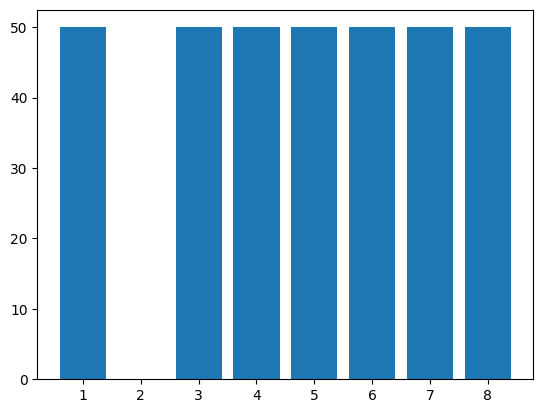

In [ ]:
plt.bar(tess_df['emotion'], height=50)

In [ ]:
tess_df = tess_df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Create a copy of the combined dataframe with emotion names for data visualization
df_vis = tess_df
df_vis.emotion = tess_df.emotion.replace({1:'Neutral', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust', 8:'Surprise'})

In [ ]:
df_vis.head(20)

,path,emotion
0,/content/TESS Toronto emotional speech set dat...,Fear
1,/content/TESS Toronto emotional speech set dat...,Sad
2,/content/TESS Toronto emotional speech set dat...,Disgust
3,/content/TESS Toronto emotional speech set dat...,Neutral
4,/content/TESS Toronto emotional speech set dat...,Neutral
5,/content/TESS Toronto emotional speech set dat...,Happy
6,/content/TESS Toronto emotional speech set dat...,Surprise
7,/content/TESS Toronto emotional speech set dat...,Fear
8,/content/TESS Toronto emotional speech set dat...,Happy
9,/content/TESS Toronto emotional speech set dat...,Disgust


<ipython-input-22-17c24a982ba5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  count = sns.countplot(x='emotion', data=df_vis, palette=palette)
<ipython-input-22-17c24a982ba5>:6: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  count = sns.countplot(x='emotion', data=df_vis, palette=palette)


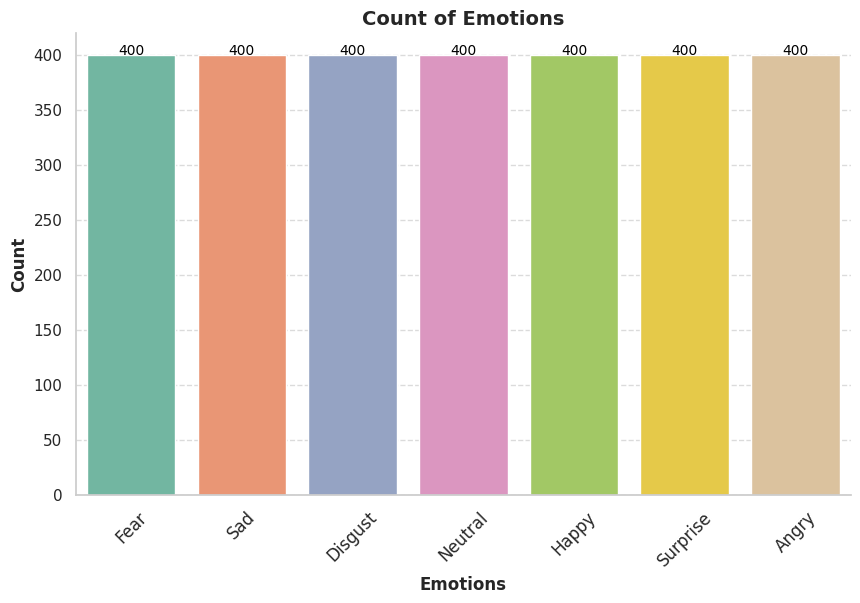

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=14, fontweight='bold')

palette = sns.color_palette("Set2")
count = sns.countplot(x='emotion', data=df_vis, palette=palette)

plt.ylabel('Count', size=12, fontweight='bold')
plt.xlabel('Emotions', size=12, fontweight='bold')

plt.xticks(rotation=45, size=12)

sns.despine(top=True, right=True)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in count.patches:
    count.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline',
                fontsize=10, color='black')


plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

In [ ]:
df_vis.path

,path
0,/content/TESS Toronto emotional speech set dat...
1,/content/TESS Toronto emotional speech set dat...
2,/content/TESS Toronto emotional speech set dat...
3,/content/TESS Toronto emotional speech set dat...
4,/content/TESS Toronto emotional speech set dat...
...,...
2795,/content/TESS Toronto emotional speech set dat...
2796,/content/TESS Toronto emotional speech set dat...
2797,/content/TESS Toronto emotional speech set dat...
2798,/content/TESS Toronto emotional speech set dat...


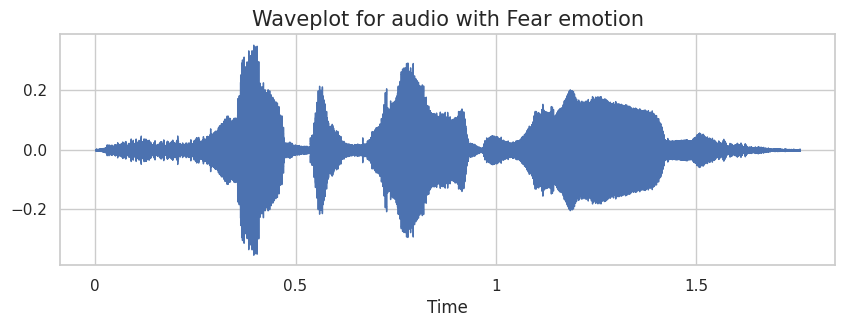

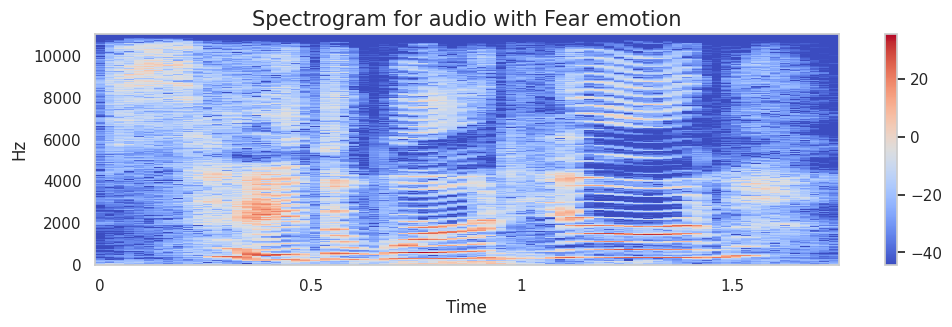

In [ ]:
emotion='Fear'
path = np.array(df_vis.path[df_vis.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

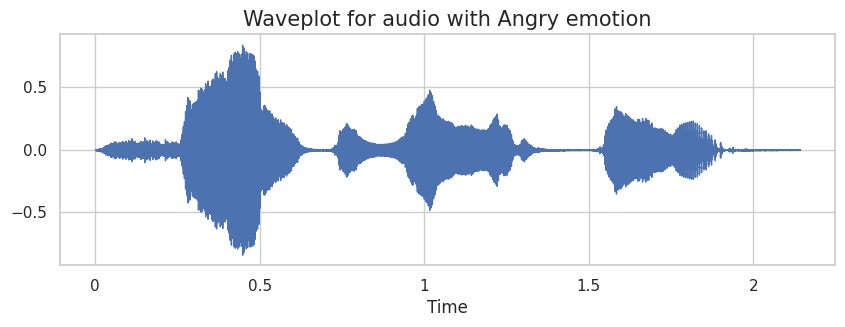

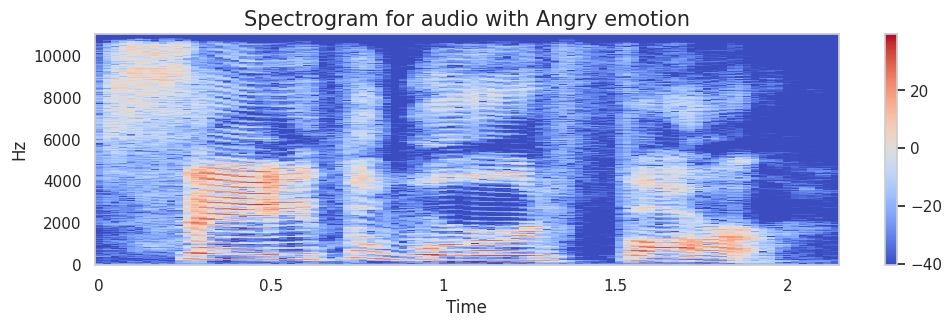

In [ ]:
emotion='Angry'
path = np.array(df_vis.path[df_vis.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

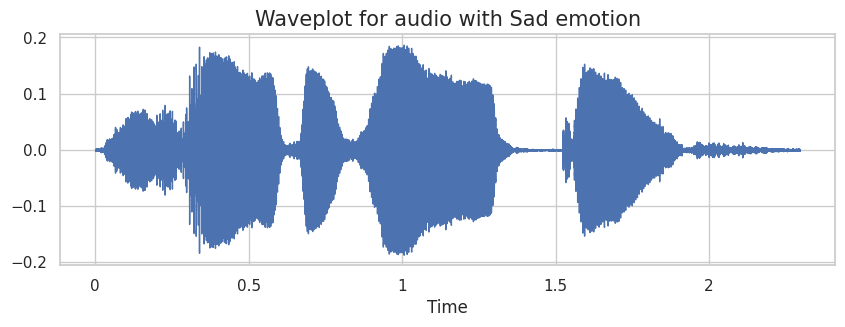

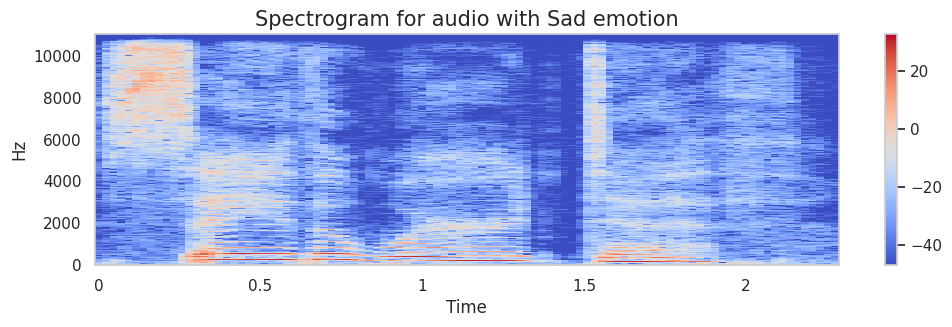

In [ ]:
emotion='Sad'
path = np.array(df_vis.path[df_vis.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

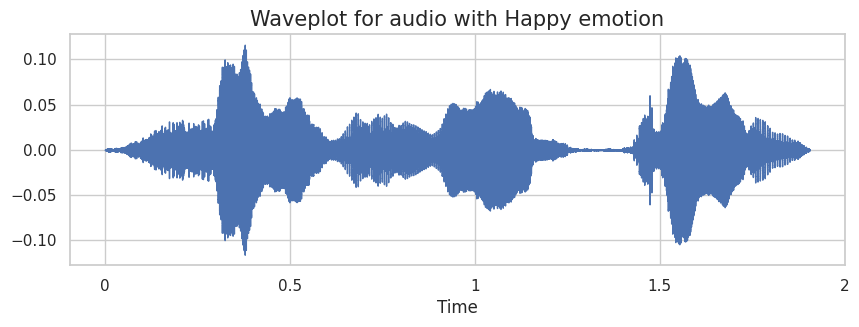

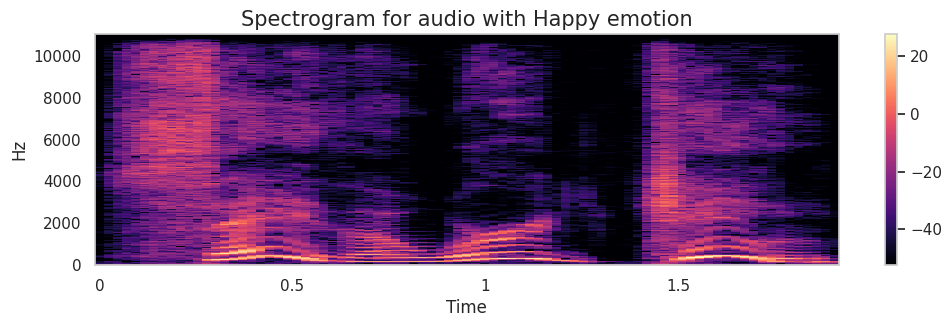

In [ ]:
emotion='Happy'
path = np.array(df_vis.path[df_vis.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, r):
    r = librosa.get_duration(y=data,sr=r)
    r = 7/r
    return librosa.effects.time_stretch(data, rate = r)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, ns = 13):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = ns)

# taking any example and checking for techniques.
path = np.array(tess_df.path)[1]
data, sample_rate = librosa.load(path)

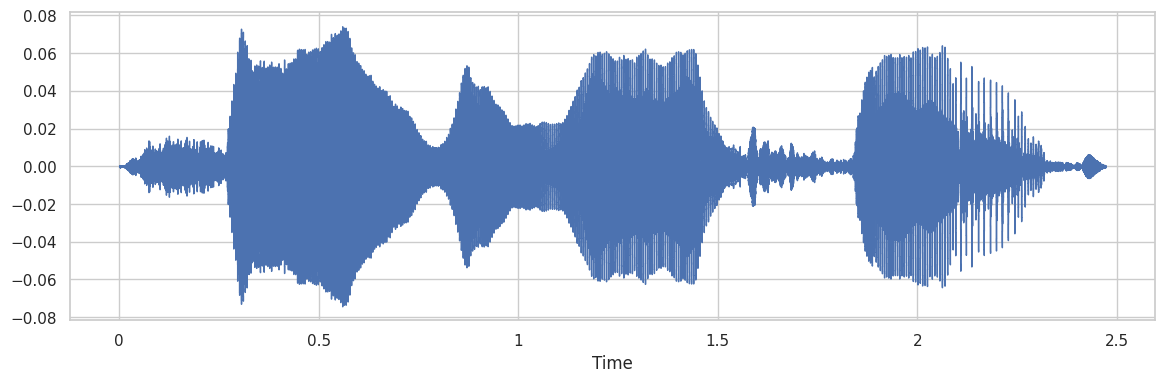

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

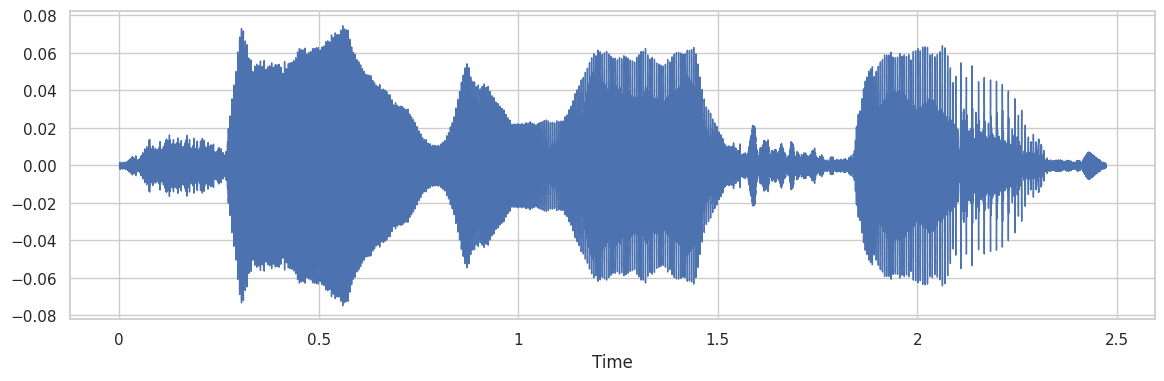

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

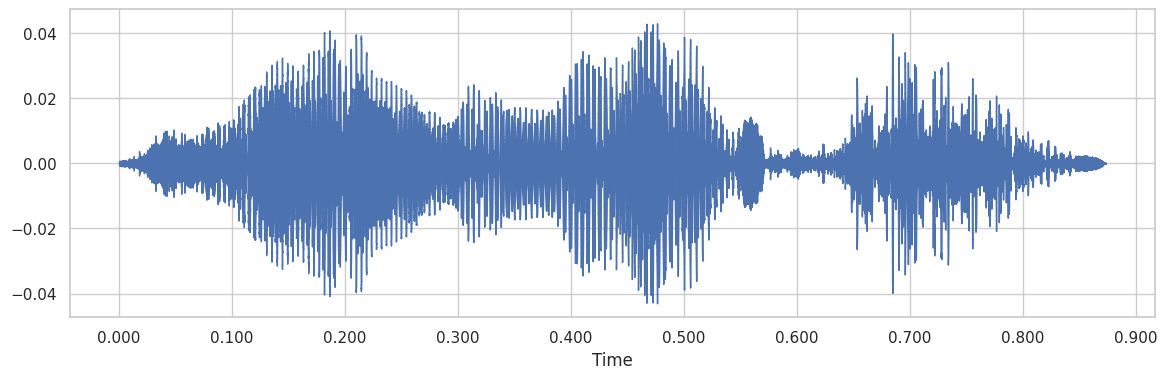

In [ ]:
x = stretch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

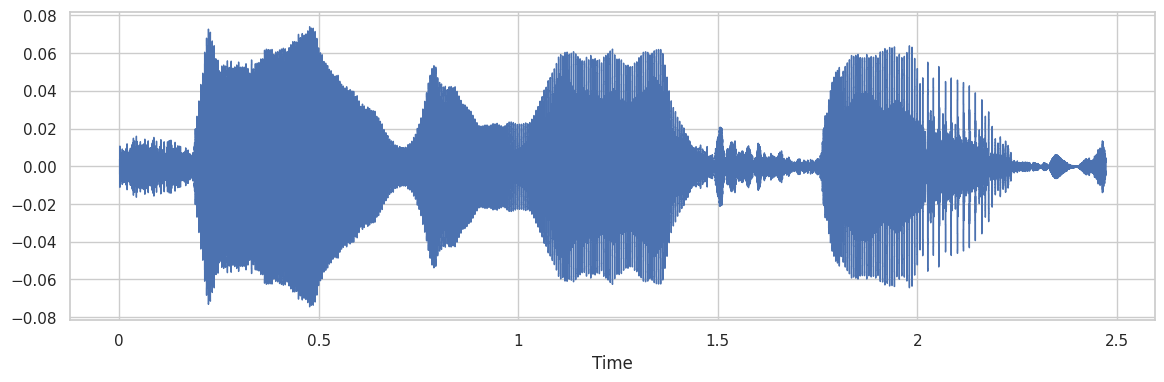

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

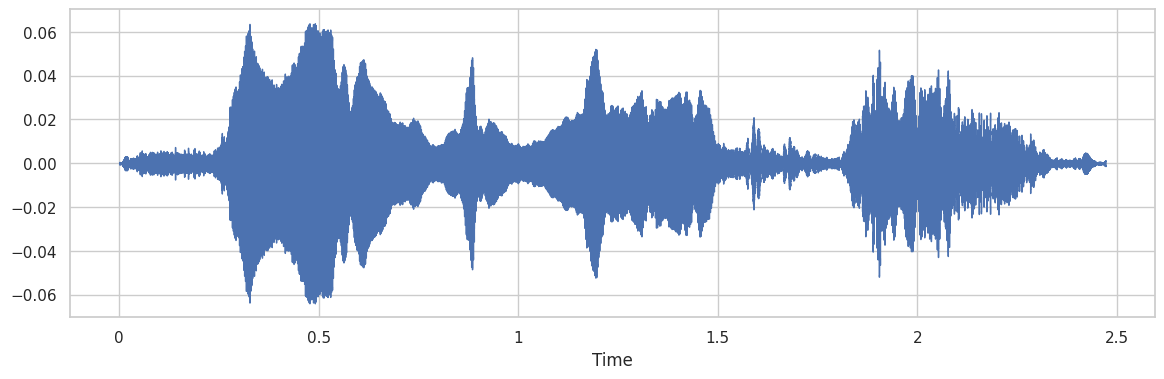

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [ ]:
def extract_feature(data, sample_rate):
    frame_length=1024
    hop_length=512
    results = np.array([])

    zcr = librosa.feature.zero_crossing_rate(y = data, frame_length=frame_length, hop_length=hop_length)
    zcr = np.squeeze(zcr)
    zcr = librosa.util.fix_length(zcr, size=108, axis=0)


    rms = np.squeeze(librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length))
    rms = librosa.util.fix_length(rms, size=108, axis=0)


    mfcc = librosa.feature.mfcc(y=data, sr=22050,n_fft=frame_length, hop_length=hop_length, n_mfcc=40)
    mfcc = np.ravel(mfcc.T)
    mfcc = librosa.util.fix_length(mfcc, size=4320, axis=0)

    results = np.hstack((results,zcr,rms,mfcc))
    return results

def get_feature(path2):
    data, sample_rate = librosa.load(path2, duration = 2.5, offset = 0.6)

#Simple data
    res1 = extract_feature(data, sample_rate)

#data with noise
    noise_data = noise(data)
    res2 = extract_feature(noise_data,sample_rate)

#data with noise
    pitch_data = pitch(data, sample_rate, ns = 13)
    res3 = extract_feature(pitch_data, sample_rate)

#pitched data with noise
    pitched_noisy_data = pitch(data, sample_rate, ns = 13)
    pitched_noisy_data = noise(pitched_noisy_data)
    res4 = extract_feature(pitched_noisy_data, sample_rate)

    return res1,res2,res3,res4

In [ ]:
X_r1,X_r2,X_r3,X_r4,y_1,y_2,y_3,y_4 = [],[],[],[],[],[],[],[]
for i in range(len(tess_df)):
    f1,f2,f3,f4=get_feature(tess_df.iloc[i].path)
    X_r1.append(f1)
    X_r2.append(f2)
    X_r3.append(f3)
    X_r4.append(f4)
    y_1.append(tess_df.iloc[i].emotion)
    y_2.append(tess_df.iloc[i].emotion)
    y_3.append(tess_df.iloc[i].emotion)
    y_4.append(tess_df.iloc[i].emotion)

In [ ]:
df1=np.array(X_r1)
df1=np.vstack((df1,X_r2))
df1=np.vstack((df1,X_r3))
df1=np.vstack((df1,X_r4))
df1=pd.DataFrame(df1)
y = y_1 + y_2 + y_3 + y_4
y = np.array(y)
X = df1

In [ ]:
Y_r = list(y)
X_r1_path = os.path.join('/content/', 'X_r1.pkl')
X_r2_path = os.path.join('/content/', 'X_r2.pkl')
X_r3_path = os.path.join('/content/', 'X_r3.pkl')
X_r4_path = os.path.join('/content/', 'X_r4.pkl')
Y_r_path = os.path.join('/content/', 'Y_r.pkl')

import pickle

with open(X_r1_path, 'wb') as f:
    pickle.dump(X_r1, f)

with open(X_r2_path, 'wb') as f:
    pickle.dump(X_r2, f)

with open(X_r3_path, 'wb') as f:
    pickle.dump(X_r3, f)

with open(X_r4_path, 'wb') as f:
    pickle.dump(X_r4, f)

with open(Y_r_path, 'wb') as f:
    pickle.dump(Y_r, f)

print(f"X_r1 and X_r2 saved to: {X_r1_path}, {X_r2_path}")

In [ ]:
from google.colab import files
import zipfile
filename= "/content/drive/MyDrive/tess/features_tess.zip"

with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('/content')


extracted_files = os.listdir('/content')
print('Extracted files:', extracted_files)

Extracted files: ['.config', 'tess toronto emotional speech set data', 'toronto-emotional-speech-set-tess.zip', 'TESS Toronto emotional speech set data', 'scaler.pkl', 'X_r2.pkl', 'drive', 'X_r1.pkl', 'X_r4.pkl', 'X_r3.pkl', 'Y_r.pkl', 'sample_data']


In [ ]:
import pickle
X_r1_path=r'/content/X_r1.pkl'
X_r2_path=r'/content/X_r2.pkl'
X_r3_path=r'/content/X_r3.pkl'
X_r4_path=r'/content/X_r4.pkl'
Y_r_path=r'/content/Y_r.pkl'
scaler_path=r'/content/scaler.pkl'

try:
  with open(X_r1_path, 'rb') as f:
      X_r1 = pickle.load(f)

  with open(X_r2_path, 'rb') as f:
      X_r2 = pickle.load(f)

  with open(X_r3_path, 'rb') as f:
      X_r3 = pickle.load(f)

  with open(X_r4_path, 'rb') as f:
      X_r4 = pickle.load(f)

  with open(Y_r_path, 'rb') as f:
      Y_r = pickle.load(f)

  with open(scaler_path, 'rb') as f:
      scaler = joblib.load(f)

  print("X_r1, X_r2, X_r3, X_r4 and Y_r loaded successfully!")
except FileNotFoundError:
  print("Saved data not found. Please ensure you saved X_r1, X_r2, X_r3, X_r4 and Y_r in the working directory.")
df1=pd.DataFrame(np.concatenate((X_r1,X_r2,X_r3,X_r4),axis=0))
y = Y_r
y = np.array(y)
X = df1

X_r1, X_r2, X_r3, X_r4 and Y_r loaded successfully!


In [ ]:
df1.shape

(11200, 4536)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

In [ ]:
from sklearn.preprocessing import StandardScaler


#Normalize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scalled = scaler.transform(X_train)
X_test_scalled = scaler.transform(X_test)
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [ ]:
import keras.utils
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

lb = OneHotEncoder()

y_train_lb = lb.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test_lb = lb.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train_lb.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test_lb.shape}')

X_train shape: (7840, 4536)
y_train shape: (7840, 7)
X_test shape: (3360, 4536)
y_test shape: (3360, 7)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dropout, Dense, MaxPool1D, AvgPool1D
import tensorflow as tf

CNN_model = tf.keras.models.Sequential([
                      Conv1D(512, 5, padding='same', input_shape=(4536, 1), activation='relu'),
                      BatchNormalization(),
                      AvgPool1D(padding='same',strides=3,pool_size=5),
                      Dropout(0.6),

                      Conv1D(64, 5, padding='same', activation='relu'),
                      BatchNormalization(),

                      Conv1D(32, 5, padding='same', activation='relu'),
                      BatchNormalization(),
                      Dropout(0.3),

                      Flatten(),
                      Dense(256,activation='relu'),
                      Dropout(0.37),
                      Dense(128,activation='relu'),
                      Dense(7,activation='softmax')

])
CNN_model.compile(loss = 'categorical_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
X_train.shape

(7840, 4536)

In [ ]:
x_traincnn = np.expand_dims(X_train_scalled, axis=2)
x_testcnn = np.expand_dims(X_test_scalled, axis=2)

#Check shapes of dataframes
print(x_traincnn.shape)
print(x_testcnn.shape)

(7840, 4536, 1)
(3360, 4536, 1)


In [ ]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4536, 512)           │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4536, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, 1512, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1512, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1512, 64)            │         163,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1512, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 1512, 32)            │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1512, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1512, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 48384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      12,386,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,600,039 (48.07 MB)

 Trainable params: 12,598,823 (48.06 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [ ]:
#Model fit
cnn_results = CNN_model.fit(x_traincnn, y_train_lb,
              batch_size = 64,
              epochs = 10,
              verbose = 1,
              validation_data = (x_testcnn, y_test_lb),
              callbacks=[check_loss,check_acc,reduce_lr])

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7958 - loss: 0.9149
Epoch 1: val_loss improved from inf to 0.53830, saving model to saved_models/weights.best.basic_cnn-1.keras

Epoch 1: val_accuracy improved from -inf to 0.78839, saving model to saved_models/weights.best.basic_cnn-2.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.7966 - loss: 0.9118 - val_accuracy: 0.7884 - val_loss: 0.5383 - learning_rate: 0.0010
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9736 - loss: 0.1731
Epoch 2: val_loss improved from 0.53830 to 0.11313, saving model to saved_models/weights.best.basic_cnn-1.keras

Epoch 2: val_accuracy improved from 0.78839 to 0.96369, saving model to saved_models/weights.best.basic_cnn-2.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 178ms/step - accuracy: 0.9736 - loss: 0.1732 - val_accuracy: 0.9637 - val_loss: 0.1131 - learning_rate: 0.0010
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9782 - loss: 0.14

In [ ]:
# Evaluating the model on the training and testing set
score = CNN_model.evaluate(x_traincnn, y_train_lb, verbose=0)
print("Training Accuracy: ", score[1] * 100)

score = CNN_model.evaluate(x_testcnn, y_test_lb, verbose=0)
print("Testing Accuracy: ", score[1] * 100)

Training Accuracy:  99.64285492897034
Testing Accuracy:  99.34523701667786


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9925 - loss: 0.0706
Accuracy of our model on test data : 99.3452%


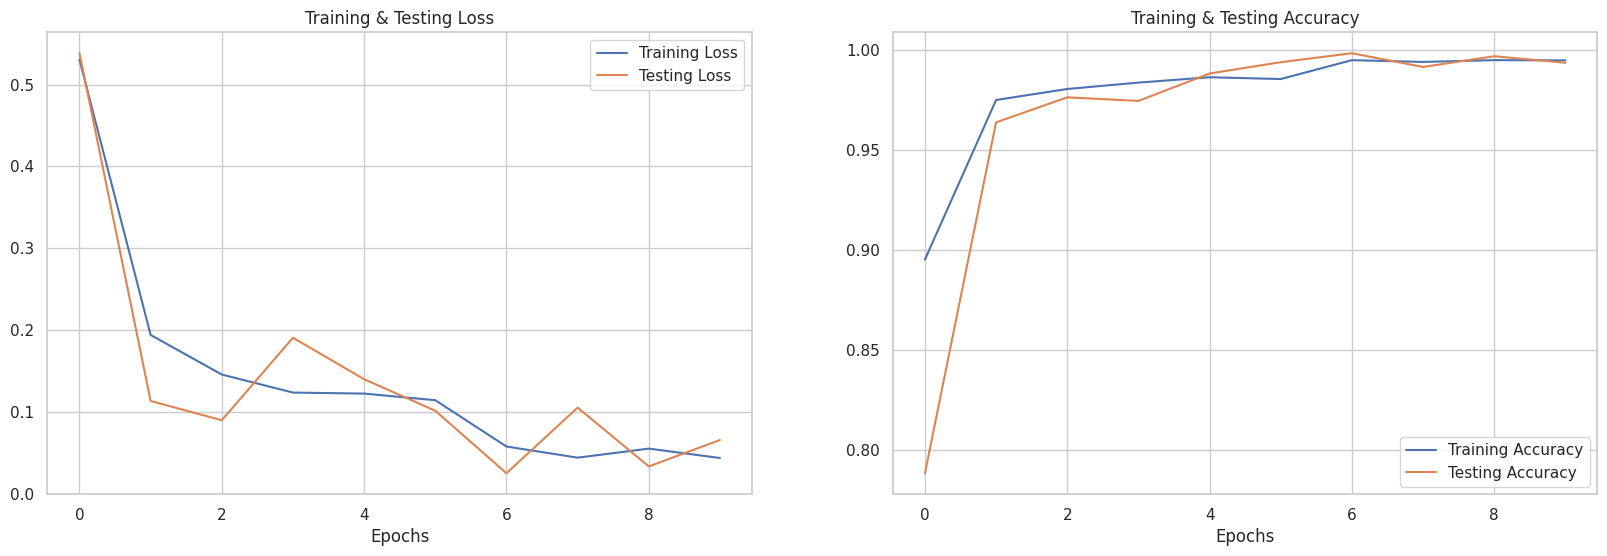

In [ ]:
score = CNN_model.evaluate(x_testcnn,y_test_lb)[1]*100
print("Accuracy of our model on test data : %.4f%%" % score )

epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = cnn_results.history['accuracy']
train_loss = cnn_results.history['loss']
test_acc = cnn_results.history['val_accuracy']
test_loss = cnn_results.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [ ]:
# predicting on test data.
pred_test0 = CNN_model.predict(x_testcnn)
y_pred0 = lb.inverse_transform(pred_test0)
y_test0 = lb.inverse_transform(y_test_lb)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


,Predicted Labels,Actual Labels
0,Disgust,Disgust
1,Sad,Sad
2,Surprise,Surprise
3,Happy,Happy
4,Angry,Angry
5,Surprise,Surprise
6,Disgust,Disgust
7,Surprise,Surprise
8,Neutral,Neutral
9,Sad,Sad


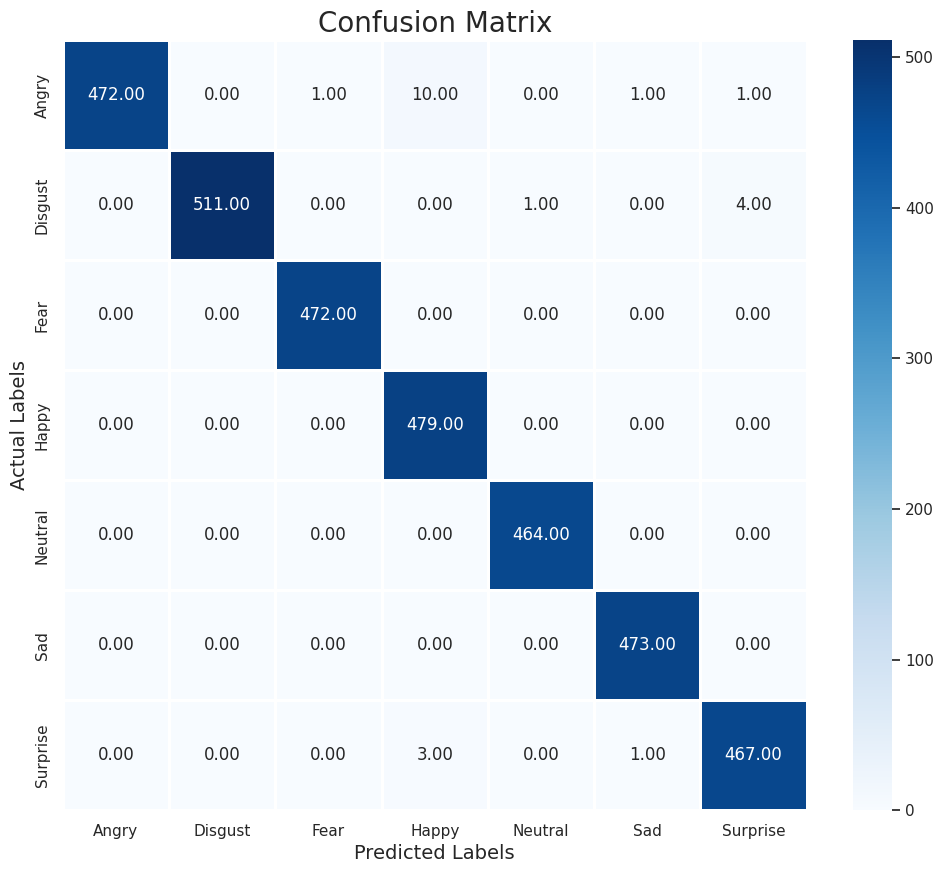

              precision    recall  f1-score   support

       Angry       1.00      0.97      0.99       485
     Disgust       1.00      0.99      1.00       516
        Fear       1.00      1.00      1.00       472
       Happy       0.97      1.00      0.99       479
     Neutral       1.00      1.00      1.00       464
         Sad       1.00      1.00      1.00       473
    Surprise       0.99      0.99      0.99       471

    accuracy                           0.99      3360
   macro avg       0.99      0.99      0.99      3360
weighted avg       0.99      0.99      0.99      3360



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.categories_] , columns = [i for i in lb.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))